In [7]:
import pyvisa as visa
from datetime import datetime
import numpy as np
import time
import matplotlib.pyplot as plt


###############################################################################
# Basics of using Virtual Instrument Software Architecture (VISA) to connect to
# instruments and sending Standard Commands for Programmable Instruments (SCPI)
# commands.
###############################################################################

# Instantiate the VISA Resource Manager
rm = visa.ResourceManager()

# Print the available resources
print("Available resources:")
print(rm.list_resources())
print("")

# Connect to specific devices
scope = rm.open_resource("USB0::0x0957::0x1798::MY51330365::INSTR")
function_generator = rm.open_resource("USB0::0x1AB1::0x0642::DG1ZA213804150::INSTR")

# There are 3 ways to transfer data between our PC and an instrument
#   write: send data from the PC to the instrument
#    read: request data from the instrument to the PC
#   query: perform a write followed by a read
# SCPI commands that generate a response end with a '?'

# Query the identity of the instruments. This typically contains information
# like the manufacturer, model number, and serial number.
scope_id = scope.query("*IDN?")
function_generator_id = function_generator.query("*IDN?")

# When the devices report their identification, there is newline character at
# the end. The following removes it.
scope_id = scope_id.rstrip("\n")
function_generator_id = function_generator_id.rstrip("\n")

print(f"Hello, I am a {scope_id}")
print(f"And I am a {function_generator_id}")
print("Instruments are ready to go!\n")


function_generator.write("OUTP1 ON")
function_generator.write(":SOUR1:FREQ 20000")
function_generator.write(":SOUR1:VOLT 10")
#function_generator.read()
#function_generator.write(":SOUR1:PER 100")

# Parameters for the experiment
min_frequency  =  3  # Hz
max_frequency  =  5.301029995664  # Hz
step_frequency =  50  # Hz

# Generate the frequencies we want to sweep over
#set_frequencies = np.arange(min_frequency, max_frequency, step_frequency)
set_frequencies = np.logspace(min_frequency, max_frequency, step_frequency)

data = np.empty((set_frequencies.shape[0], 3)).astype(np.float32)
data[:,0] = set_frequencies

scope.write("TRIG:SOUR CHAN4")

scope.write(":CHAN2:SCAL 1mV")
scope.write(":CHAN1:SCAL 1mV")
scope.write(":FUNC:SCAL 1mV")

print("Frequency \t VAmplitude \t Phase M->4 ")
scope.write(":MEASURE:SOURCE CHANNEL1")
for datum in data:
		function_generator.write(f":SOURCE1:FREQUENCY {datum[0]}")
		scope.write(f":MEAS:VAMP MATH {datum[0]}")
		tscale = str(5/datum[0])
		scope.write(":TIM:RANG " + tscale)
		time.sleep(0.5)
		scope.write("STOP")
		datum[1] = scope.query(":MEASure:PHASe? MATH, CHAN4").rstrip("\n")
		datum[2] = scope.query(f":MEAS:VAMP? MATH")
		if datum[2] < 0.005:
			scope.write(":FUNC:SCAL 1mV")
		elif 0.005 <= datum[2] <= 0.015 :
			scope.write(":FUNC:SCAL 3mV")
		else:
			scope.write(":FUNC:SCAL 10mV")
		if datum[2] > 0.015:
			scope.write(":CHAN2:SCAL 5mV")
			scope.write(":CHAN1:SCAL 5mV")
			scope.write(":FUNC:SCAL 3mV")
		else:
			scope.write(":CHAN2:SCAL 2mV")
			scope.write(":CHAN1:SCAL 2mV")
		# The 18 and 23 are field (column) widths to keep the output aligned
		# The < means to left align in the column
		datumround = np.round(datum[0], 1)
		print(f"{datumround:<18}\t{datum[2]:<23}\t{datum[1]:<23}")
		scope.write("RUN")
        
now = datetime.now()
timestamp = now.strftime("%d/%m/%Y %H:%M:%S")

#Output the data into a CSV file with a header
with open("NormIn.csv", "w") as fp:
	fp.write(f"%{timestamp}\n")
	fp.write(f"%Oscilloscope: {scope_id}\n")
	fp.write(f"%Function Generator: {function_generator_id}\n")
	fp.write("%Frequency,PHASE M->4,VAmplitude\n")
	np.savetxt(fp, data, delimiter=",")


Available resources:
('USB0::0x1AB1::0x0C94::DM3O225000989::INSTR', 'USB0::0x0957::0x0A07::MY48002584::INSTR')



VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

0.9843406583159575


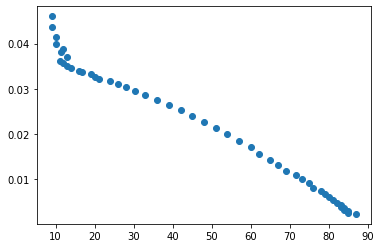

In [2]:
from scipy import stats
phase = np.transpose(data[:, 1].tolist())
amp = np.transpose(data[:, 2].tolist())
freq = np.transpose(data[:, 0].tolist())

slope, intercept, r, p, std_err = stats.linregress(phase, amp)
print(r**2)
plt.scatter(phase, amp)

18